In [2]:
""" Import zone """

import math
import html
import datetime

import numpy as np
import pandas as pd
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer; nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer

from sklearn.metrics import silhouette_score

import spacy; spacy_nlp = spacy.load("en_core_web_sm", disable=['ner', 'entity_linker', 'entity_ruler', 'textcat', 'textcat_multilabel', 'morphologizer', 'senter', 'sentencizer', 'transformer'])

# !pip install git+https://github.com/PimpMyGit/Comodo.git
from comodo.comodo.comodo import * # if fail try from comodo.comodo import *

import support
register_consts(support.comodo_config)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tommaso\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\tommaso\AppData\Roaming\Python\Python39\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tommaso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Done → COMODO.COMODO.CONSTANTS in register_consts() → Comodo's costants correctly configured


In [2]:
""" Lettura DataFrame e piccole modifiche di formato """

trdf = DF.rcsv('original/drugsComTrain_raw', sep='\t')
del trdf['Unnamed: 0']
trdf.columns = ['drug', 'condition', 'review', 'rating', 'date', 'useful']
trdf['date'] = trdf['date'].apply(lambda d: UTILS.to_datetime(d, '%B %d, %Y', as_str=True))
trdf = trdf.sort_values('date')

tsdf = DF.rcsv('original/drugsComTest_raw', sep='\t')
del tsdf['Unnamed: 0']
tsdf.columns = ['drug', 'condition', 'review', 'rating', 'date', 'useful']
tsdf['date'] = tsdf['date'].apply(lambda d: UTILS.to_datetime(d, '%B %d, %Y', as_str=True))

print('DF Train shape:  ', trdf.shape, '    NaN:', DF.has_nan(trdf))
print('DF Test shape:   ', tsdf.shape, '     NaN:', DF.has_nan(tsdf))

print('Drop NaN then..', '\n')
trdf = trdf.dropna()
tsdf = tsdf.dropna()

print('Reparir: delete records with "users found this comment helpful *" and add an upper "F" to not-capitalized condition', '\n')
trdf = DF.add_order_column(trdf)
tsdf = DF.add_order_column(tsdf)
trdf = DF.find(trdf, {'order': ['!']+DF.find(trdf, {'condition':['re','users found*']})['order'].to_list()}).copy()
tsdf = DF.find(tsdf, {'order': ['!']+DF.find(tsdf, {'condition':['re','users found*']})['order'].to_list()}).copy()
trdf['condition'] = trdf['condition'].apply(lambda c: 'F'+c if c[0].islower() else c)
tsdf['condition'] = tsdf['condition'].apply(lambda c: 'F'+c if c[0].islower() else c)

print('DF Train shape:  ', trdf.shape, '    NaN:', DF.has_nan(trdf))
print('DF Test shape:   ', tsdf.shape, '     NaN:', DF.has_nan(tsdf))
trdf = DF.add_order_column(trdf)
tsdf = DF.add_order_column(tsdf)

# DF.wcsv(trdf, 'start/train_df.csv', sep='\t')
# DF.wcsv(tsdf, 'start/test_df.csv', sep='\t')

DF Train shape:   (161297, 6)     NaN: {'nan_percentage': 0.005573569254232875, 'condition': 899}
DF Test shape:    (53766, 6)      NaN: {'nan_percentage': 0.0054867388312316336, 'condition': 295}
Drop NaN then.. 

Reparir: delete records with "users found this comment helpful *" and add an upper "F" to not-capitalized condition 

DF Train shape:   (159498, 7)     NaN: {}
DF Test shape:    (53200, 7)      NaN: {}


<hr style="border: 1px solid orange; background-color: orange">

In [2]:
""" Lettura DataFrame iniziali """

trdf = DF.set_datetime_index(DF.rcsv('start/train_df.csv', sep='\t'), 'date')
tsdf = DF.set_datetime_index(DF.rcsv('start/test_df.csv', sep='\t'), 'date')

print('DF Train shape:  ', trdf.shape, '    NaN:', DF.has_nan(trdf))
print('DF Test shape:   ', tsdf.shape, '     NaN:', DF.has_nan(tsdf))

DF Train shape:   (159498, 7)     NaN: {}
DF Test shape:    (53200, 7)      NaN: {}


In [10]:
""" Descrizione variabili """

print('[drug]       - Total drugs:      ', len(set(trdf['drug'])))
print('[condition]  - Total conditions: ', len(set(trdf['condition'])))
print('[rating]     - Ratings distr.:   ', DICT.filter_key(DF.describe(trdf, 'rating', print_res=False, print_plot=False), lambda k: k in ['mean', 'q25', 'q50', 'q75']))
print('[date]       - Date distr.:      ', {year: trdf[trdf.index.year == year].shape[0] for year in list(set(trdf.index.year))})
print('[useful]     - Useful distr.:    ', DICT.filter_key(DF.describe(trdf, 'useful', print_res=False, print_plot=False), lambda k: k in ['mean', 'q25', 'q50', 'q75', 'max']))

[drug]       - Total drugs:       3412
[condition]  - Total conditions:  811
[rating]     - Ratings distr.:    {'mean': 6.99714729965266, 'q25': 5.0, 'q50': 8.0, 'q75': 10.0}
[date]       - Date distr.:       {2016: 34697, 2017: 28013, 2008: 5011, 2009: 11464, 2010: 8097, 2011: 11308, 2012: 9717, 2013: 12195, 2014: 11969, 2015: 27027}
[useful]     - Useful distr.:     {'mean': 28.19233470012163, 'q25': 6.0, 'q50': 16.0, 'q75': 37.0, 'max': 1291.0}


In [3]:
""" Text preporcessing """

for name,function in OBJECTS._PREPROCESS_STEPS.items():
    print('Applying', name, '..')
    trdf['review'] = trdf['review'].apply(lambda s: function(s))

Applying LOWER ..
Applying NO_QUOTE ..
Applying DECODE_HTML ..
Applying NO_URL ..
Applying NO_EMOJI ..
Applying NO_ESCAPE ..
Applying NO_PUNCTUATION ..
Applying NO_NUMBERS ..
Applying NO_ELLIPSIS ..


<hr style="border: 1px solid orange; background-color: orange">

In [3]:
""" Sentence and word tokenization + POS Tagging """

# all_sentences = [sent_tokenize(review) for review in trdf['review']]
# all_words = [[word_tokenize(sentence) if len(sentence)>0 else '' for sentence in sentences] for sentences in all_sentences]
# all_pos_tag = [[nltk.pos_tag(words) for words in sentence] for sentence in all_words]

# _ = UTILS.pkl_save('pkl/all_sentences', all_sentences)
# _ = UTILS.pkl_save('pkl/all_words', all_words)
# _ = UTILS.pkl_save('pkl/all_pos_tag', all_pos_tag)

all_sentences = UTILS.pkl_load('pkl/all_sentences')
all_words = UTILS.pkl_load('pkl/all_words')
all_pos_tag = UTILS.pkl_load('pkl/all_pos_tag')

In [5]:
""" Filtering by POS Tag (N+J+V+R) -Stopwords """

lemmatizer = spacy_nlp.get_pipe("lemmatizer")
all_sentences_NJVR_lemmatized = []

for iR,review in enumerate(all_pos_tag):
    entry_review = []
    for iS,sentence in enumerate(review):
        entry_sentence = []
        
        # FILTER NJVR -STOPWORDS
        [entry_sentence.append(spacy_nlp(word[0])[0].lemma_) for word in sentence if word[1] in OBJECTS._POS_TAG['TO_KEEP'] and word[1] not in OBJECTS._STOPWORDS]
        
        entry_review.append(entry_sentence)
    all_sentences_NJVR_lemmatized.append(entry_review)

In [7]:
""" Back to Dataset """

trdf['clean_review'] = trdf.apply(lambda r: '|'.join([' '.join(sentence) for sentence in all_sentences_NJVR_lemmatized[r['order']]]), axis = 1)
trdf.head(3)

,drug,condition,review,rating,date,useful,order,prep_review
date,,,,,,,,
2008-02-24,Chlorpheniramine / pseudoephedrine,Allergic Rhinitis,i when to a medical clinic with flu like sympt...,1.0,2008-02-24,0,0,medical clinic flu symptom Dr. duty prescribe ...
2008-02-24,Oxybutynin,Not Listed / Othe,improved my problem dramatically. i never expe...,7.0,2008-02-24,22,1,improve problem dramatically|never experience ...
2008-02-24,Xenical,Obesity,xenical really helped me but some of the bowel...,7.0,2008-02-24,50,2,xenical really help bowel problem have make ma...


In [ ]:
""" SPACY Lemmatization """

trdf['prep_review'] = trdf['clean_review'].apply(lambda review: '|'.join([' '.join([spacy_nlp(word)[0].lemma_ for word in sentence.split()]) for sentence in review.split('|')]))
trdf.head(3)

<hr style="border: 1px solid orange; background-color: orange">

In [3]:
""" Starts with preprocessed datafarame """

step = 'prep'
trdf = DF.set_datetime_index(DF.rcsv(step+'/train_df.csv', sep='\t'), 'date')
trdf.head(3)

,drug,condition,review,rating,date,useful,order,clean_review,prep_review
date,,,,,,,,,
2008-02-24,Chlorpheniramine / pseudoephedrine,Allergic Rhinitis,i when to a medical clinic with flu like sympt...,1.0,2008-02-24,0,0,i medical clinic flu symptoms dr. duty prescri...,I medical clinic flu symptom dr duty prescribe...
2008-02-24,Oxybutynin,Not Listed / Othe,improved my problem dramatically. i never expe...,7.0,2008-02-24,22,1,improved problem dramatically|i never experien...,improve problem dramatically|I never experienc...
2008-02-24,Xenical,Obesity,xenical really helped me but some of the bowel...,7.0,2008-02-24,50,2,xenical really helped bowel problems i had mad...,xenical really help bowel problem I have make ...


In [131]:
""" Vocabulary """

all_vocab = []
_ = [[[all_vocab.append(w) for w in s.split()] if type(s) is str else '' for s in r.split('|')] if type(r) is str else '' for r in trdf['prep_review'].to_list()]
vocab = set(all_vocab)
vocab_occurrences = LIST.occurrences(all_vocab)
print('Vocab length:', len(vocab))

all_vocab_original = []
_ = [[all_vocab_original.append(w) if type(w) is str else '' for w in r.split(' ')] if type(r) is str else '' for r in trdf['review'].to_list()]
vocab_original = set(all_vocab_original)
vocab_original_ccurrences = LIST.occurrences(all_vocab_original)
print('Original vocab length:', len(vocab_original))

Vocab length: 37732
Original vocab length: 61580


In [132]:
""" Vocabulary Analysis"""

print('Reviews containg dot "." :', sum(list(DICT.dfilter(vocab_occurrences, lambda x: '.' in x).values())))
print('Drop all them → keep at least', str(100*(trdf.shape[0]-9000)/DF.rcsv('start/train_df.csv', sep='\t').shape[0]), '% of total')
trdf = DF.find_lambda(trdf, lambda r: '.' not in r['prep_review'] if type(r['prep_review'])is str else False)
trdf['prep_review'] = trdf['prep_review'].apply(lambda r: r.lower())
print('Now size:', trdf.shape)

Reviews containg dot "." : 9000
Drop all them → keep at least 91.62873515655369 % of total
Now size: (148256, 9)


In [133]:
""" Write DF ready for Analysis """

del trdf['clean_review']    # Non serve più, non è la definitiva
del trdf['order']           # Non congruente dopo clean finale

trdf.rename(columns={'review': 'original_review', 'prep_review': 'review'}, inplace=True)

trdf['review'] = trdf['review'].apply(lambda r: r.lower())
# Forme negative -> replace 'not# ' per tenerle | 'not' per convertire tutto in not | '' per eliminarle
trdf['review'] = trdf['review'].apply(lambda r: '|'.join([' '.join(LIST.lfilter([w if w not in OBJECTS._NEG_STOPWORDS else 'not#' for i,w in enumerate(s.split()) if w not in OBJECTS._STOPWORDS or (w in OBJECTS._STOPWORDS and w in OBJECTS._NEG_STOPWORDS)], lambda w:w!='')).replace('# ', '_') for s in r.split('|')]))

trdf['review_words'] = trdf['review'].apply(lambda r: ' '.join([' '.join(s.split()) for s in r.split('|')]))

trdf = trdf.drop_duplicates(subset='review_words')
trdf = DF.add_order_column(trdf)

trdf = trdf[['drug', 'condition', 'original_review', 'review', 'review_words', 'rating', 'useful', 'date', 'order']]

DF.wcsv(trdf, 'analysis/train_df.csv', sep='\t')

<hr style="border: 1px solid orange; background-color: orange">

In [3]:
""" Read DF for analysis """

trdf = DF.set_datetime_index(DF.rcsv('analysis/train_df.csv', sep='\t'), 'date')
trdf.head(10)

,drug,condition,original_review,review,review_words,rating,useful,date,order,review_words_luhn,all_bg,jn_constr,vj_constr,rj_constr,rv_constr,vr_constr
date,,,,,,,,,,,,,,,,
2008-02-24,Chlorpheniramine / pseudoephedrine,Allergic Rhinitis,i when to a medical clinic with flu like sympt...,medical clinic flu symptom dr duty prescribe d...,medical clinic flu symptom dr duty prescribe d...,1.0,0,2008-02-24,0,medical clinic flu symptom dr duty know seriou...,symptom dr|flu symptom,NaN,NaN,NaN,symptom dr,flu symptom
2008-02-24,Oxybutynin,Not Listed / Othe,improved my problem dramatically. i never expe...,improve problem dramatically|never experience ...,improve problem dramatically never experience ...,7.0,22,2008-02-24,1,improve dramatically major,experience major|never experience,NaN,experience major,NaN,never experience,NaN
2008-02-24,Xenical,Obesity,xenical really helped me but some of the bowel...,xenical really help bowel problem make margina...,xenical really help bowel problem make margina...,7.0,50,2008-02-24,2,xenical bowel marginal hit,hit side,NaN,NaN,NaN,NaN,hit side
2008-02-24,Macrobid,Bladder Infection,excellent for prevention of bladder infection ...,excellent prevention bladder infection cns com...,excellent prevention bladder infection cns com...,8.0,52,2008-02-24,3,excellent prevention bladder infection cns com...,bladder infection,NaN,bladder infection,NaN,NaN,NaN
2008-02-25,Fentanyl,Pain,i don t think i could make it without the patc...,not_think make patch|pain back point live|fent...,not_think make patch pain back point live fent...,10.0,22,2008-02-25,4,not_think patch point live patch way,make patch|much pain|not_think make|take much|...,make patch|much pain,not_think make|take much,NaN,NaN,point live
2008-02-25,Humira,"Crohn's Disease, Maintenance",my name is serena. i have had chron s disease ...,name serena|chron disease year|surgery year ag...,name serena chron disease year surgery year ag...,10.0,111,2008-02-25,5,name disease surgery flare surgery gi humira m...,flare week|normal life|get lead|put humira|gi ...,flare week|normal life,NaN,get lead,put humira,gi put|humira miracle
2008-02-25,Buprenorphine,Opiate Dependence,it s works great if your really ready to stop ...,work great really ready stop take opiate,work great really ready stop take opiate,8.0,78,2008-02-25,6,ready opiate,really ready|stop take|ready stop,NaN,NaN,NaN,really ready|stop take,ready stop
2008-02-25,Methylphenidate,ADHD,my son was taking the mg for yrs when all of a...,son take mg yrs sudden start get severely depr...,son take mg yrs sudden start get severely depr...,5.0,159,2008-02-25,7,son yrs sudden severely depressed thought hurt...,small percentage|seem small|severely depressed...,small percentage,seem small,NaN,severely depressed|immediately take,sudden start|take concerta|read side|read side
2008-02-25,Balsalazide,Ulcerative Colitis,there is new generic version of colazal now. i...,new generic version colazal|wonder anyone use ...,new generic version colazal wonder anyone use ...,10.0,16,2008-02-25,8,new generic version colazal wonder anyone vs b...,wonder anyone|vs brand|name drug|use find,wonder anyone|vs brand|name drug,NaN,NaN,NaN,use find


In [7]:
""" Remove condtions under 35 reviews """

keep_condition = list(DICT.dfilter(LIST.occurrences(trdf['condition']), by='value', lambda_fun=lambda v: v>=35).keys())
trdf = DF.find(trdf, {'condition': keep_condition})

print('Now size:', trdf.shape[0])
print('Kept conditions:', len(keep_condition))

Now size: 102012
Kept conditions: 225


In [9]:
""" Raggruppo per condizione """

# Insomnia
# Back Pain
# Anxiety
# Depression
# ADHD
# Obesity
# Birth Control
# Erectile Dysfunction
# Vaginal Yeast Infection

target_condition = 'Vaginal Yeast Infection'

gr_condition = trdf.groupby('condition')
grc = gr_condition.get_group(target_condition)

DO_ENTIRE_DATAFRAME = False

grc = trdf.copy() if DO_ENTIRE_DATAFRAME else grc.copy()

<hr>

# Describe variable: values

• n obs :   4145
• mean :   1.13729794933655
• variance :   2.068999453917126
• std :   1.3101193684075858
• min :   0.0
• q25 :   0.0
• q50 :   0.0
• q75 :   1.0
• max :   7.0
• range :   7.0
• skewness :   1.3721939602229216
• kurtosis :   1.4507112878906554




C:\Users\tommaso\AppData\Local\Temp/ipykernel_19332/2235372927.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grc['review_words_luhn'] = grc['review_words'].apply(lambda r: ' '.join([w for w in r.split() if w in keep_vocab]) if type(r) is str else ' ')


<Figure size 432x288 with 0 Axes>

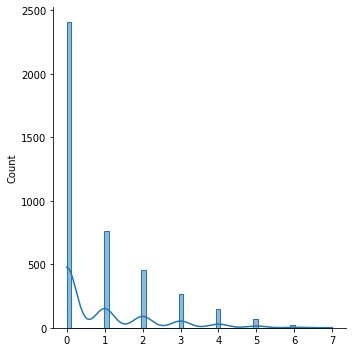

In [11]:
""" Filter Luhn Analysis """

def get_vocab(df, text_col='review_words'):
    all_vocab = []
    _ = [[all_vocab.append(w) for w in r.split()] for r in df[text_col].to_list() if type(r) is str]
    vocab_occurrences = LIST.occurrences(all_vocab)
    return vocab_occurrences

# Distribution of log-corrected vocab occurrencies
vocab = get_vocab(grc)
vocab_log = DICT.apply_value(vocab, lambda f: round(UTILS.log(f), ndigits=1))
vocab_log_distr = LIST.describe(vocab_log.values(), print_res=True, print_plot=True)

# Keep from floor(skewness) to max-ceil(skewness)
l_cutoff, u_cutoff = round(vocab_log_distr['skewness']), int(vocab_log_distr['max'])-math.ceil(vocab_log_distr['skewness'])
keep_vocab = list(DICT.filter_value(vocab_log, lambda l: l_cutoff <= l and l <= u_cutoff).keys())

# Filter luhn words
grc['review_words_luhn'] = grc['review_words'].apply(lambda r: ' '.join([w for w in r.split() if w in keep_vocab]) if type(r) is str else ' ')

<hr>
<h3>Bigrams Constructs</h3>

In [9]:
""" POS dict """
pos_dict = UTILS.pkl_load('pkl/pos_dict.pkl')

In [10]:
""" W2V Building """

# all_sentences = []
# for r in trdf['review'].to_list():
#   if type(r) is str: 
#       [all_sentences.append([w for w in s.split() if ((w in pos_dict and pos_dict[w][0] in ['N','J','V','R']) or UTILS.start_with(w,'not_'))]) for s in r.split('|')]

# w2v_model_150 = ML.w2v(all_sentences, model='SG', vector_size=150, get_bigrams=True)
# w2v_model_300 = ML.w2v(all_sentences, model='SG', vector_size=300, get_bigrams=True)
# UTILS.pkl_save('pkl/w2v_150_NEGnot.pkl', w2v_model_150)
# UTILS.pkl_save('pkl/w2v_300_NEGnot.pkl', w2v_model_300)

# Loading Models
w2v_model = UTILS.pkl_load('pkl/w2v_150_NEGnot.pkl')
w2v_vocab = w2v_model.wv.key_to_index

In [11]:
""" Cerca costrutti grammaticali """

jn_constr = ('J', 'N')      # aggettivo  +  nome            # conoscienza comune
vj_constr = ('V', 'J')      # verbo      +  aggettivo       # https://www.grammarly.com/blog/adjective-and-verb-placement/#:~:text=Adjectives%20are%20usually%20placed%20before,are%20placed%20after%20the%20verb.&text=%E2%80%9CSense%E2%80%9D%20verbs%2C%20such%20as,The%20cookies%20smell%20awesome%20!
rj_constr = ('R', 'J')      # avverbio   +  aggettivo       # https://site.uit.no/english/grammar/adverb-placement/#:~:text=Adverbs%20can%20be%20used%20to,%2C%20recently%20re%2Delected%20president.
rv_constr = ('R', 'V')      # avverbio   +  verbo           # https://site.uit.no/english/grammar/adverb-placement/#:~:text=Adverbs%20can%20be%20used%20to,%2C%20recently%20re%2Delected%20president.
vr_constr = ('V', 'R')      # verbo      +  avverbio        # https://site.uit.no/english/grammar/adverb-placement/#:~:text=Adverbs%20can%20be%20used%20to,%2C%20recently%20re%2Delected%20president.
grammar_constrs = [jn_constr, vj_constr, rj_constr, rv_constr, vr_constr]

# Considerare parole che esistono anche in w2v_vocab
do_check_vocab = True 
check_vocab = w2v_vocab #list(set(affspace['concept'].to_list()))
def get_biConstrcut(sentence, construct):
    constructs = []
    if type(sentence) is str:
        words = sentence.split()

        _ = [constructs.append([w, words[i+1]]) for i,w in enumerate(words[:-1]) if (((w in check_vocab and words[i+1] in check_vocab) or (UTILS.start_with(w,'not_')  and UTILS.start_with(words[i+1],'not')) if do_check_vocab else True) and
                                                                                    ((w in pos_dict and pos_dict[w][0]==construct[0] and words[i+1] in pos_dict and pos_dict[words[i+1]][0]==construct[1]) or 
                                                                                    ((w in pos_dict and pos_dict[w][0]==construct[0] and (UTILS.start_with(words[i+1],'not_') and words[i+1][len('not_'):] in pos_dict and pos_dict[words[i+1][len('not_'):]][0]==construct[1])) or 
                                                                                     ((UTILS.start_with(w,'not_') and w[len('not_'):] in pos_dict and pos_dict[w[len('not_'):]][0]==construct[0]) and words[i+1] in pos_dict and pos_dict[words[i+1]][0]==construct[1] ))))]
    return constructs

def sentences_biContruct(sentences, construct, to_str=False):
    constr_list = []
    if type(sentences) is str:
        _ = [[constr_list.append(c) for c in sc] for sc in LIST.lfilter([get_biConstrcut(s, construct) for s in sentences.split('|')], lambda v: len(v)>0)]
    if to_str:
        return '|'.join([' '.join(w) for w in constr_list])
    else:
        return constr_list

grc['all_bg'] = ''
for grammar_constr in grammar_constrs:
    column_name = grammar_constr[0].lower()+grammar_constr[1].lower()+'_'+'constr'
    grc[column_name] = grc['review'].apply(lambda review: sentences_biContruct(review, grammar_constr, to_str=True))
    grc['all_bg'] = grc.apply(lambda r:r['all_bg'] + ('|' if r[column_name]!='' and r['all_bg']!='' else '') + r[column_name], axis=1)
# grc['all_bg'] = grc['all_bg'].apply(lambda bgl: UTILS.str_replace(bgl, {' ':'_','|':' '}))

# DF.wcsv(grc, 'grc/'+target_condition+'.csv', sep='\t')

print('shape:', grc.shape)
grc.head(5)

shape: (102012, 16)


,drug,condition,original_review,review,review_words,rating,useful,date,order,review_words_luhn,all_bg,jn_constr,vj_constr,rj_constr,rv_constr,vr_constr
date,,,,,,,,,,,,,,,,
2008-02-24,Chlorpheniramine / pseudoephedrine,Allergic Rhinitis,i when to a medical clinic with flu like sympt...,medical clinic flu symptom dr duty prescribe d...,medical clinic flu symptom dr duty prescribe d...,1.0,0,2008-02-24,0,medical clinic flu symptom dr duty know seriou...,symptom dr|flu symptom,,,,symptom dr,flu symptom
2008-02-24,Oxybutynin,Not Listed / Othe,improved my problem dramatically. i never expe...,improve problem dramatically|never experience ...,improve problem dramatically never experience ...,7.0,22,2008-02-24,1,improve dramatically major,experience major|never experience,,experience major,,never experience,
2008-02-24,Xenical,Obesity,xenical really helped me but some of the bowel...,xenical really help bowel problem make margina...,xenical really help bowel problem make margina...,7.0,50,2008-02-24,2,xenical bowel marginal hit,hit side,,,,,hit side
2008-02-24,Macrobid,Bladder Infection,excellent for prevention of bladder infection ...,excellent prevention bladder infection cns com...,excellent prevention bladder infection cns com...,8.0,52,2008-02-24,3,excellent prevention bladder infection cns com...,bladder infection,,bladder infection,,,
2008-02-25,Fentanyl,Pain,i don t think i could make it without the patc...,not_think make patch|pain back point live|fent...,not_think make patch pain back point live fent...,10.0,22,2008-02-25,4,not_think patch point live patch way,make patch|much pain|not_think make|take much|...,make patch|much pain,not_think make|take much,,,point live
